<a href="https://colab.research.google.com/github/kirankumareranki/AIML-2025/blob/main/Lab05-AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression with Titanic data set

## Import packages and dataset

In [4]:
#import nbconvert #recode the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = pd.read_csv('/content/titanic_train.csv') # Training set is already available
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Check basic info about the data set including missing value

In [5]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
d=train.describe()
d

## Exploratory analysis and plots

**Plot a bar diagram to check the number of numeric entries**

From the bar diagram, it shows that there are some age entries missing as the number of count for 'Age' is less than the other counts.<br> We can do some impute/transformation of the data to fill-up the missing entries.

Text(0.5, 1.0, 'Bar plot of the count of numeric features')

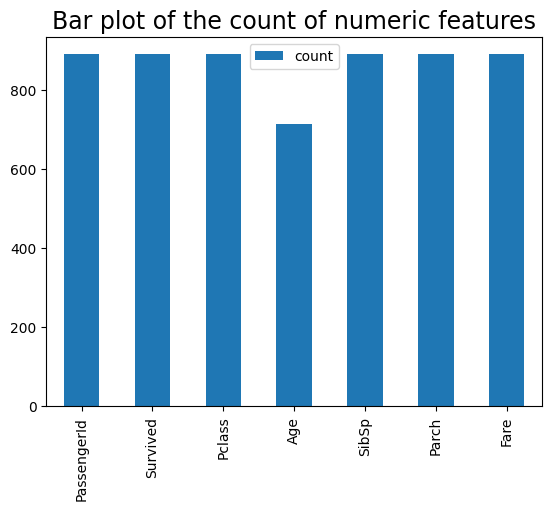

In [7]:
dT=d.T
dT.plot.bar(y='count')
plt.title("Bar plot of the count of numeric features",fontsize=17)

**Check the relative size of survived and not-survived**

<Axes: xlabel='Survived', ylabel='count'>

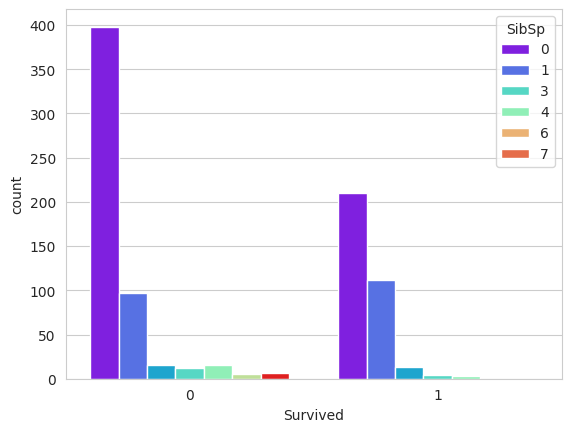

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='SibSp',data=train,palette='rainbow')
#sns.pairplot(train)

**Is there a pattern for the survivability based on sex?**

It looks like more female survived than males!

<AxesSubplot:xlabel='Survived', ylabel='count'>

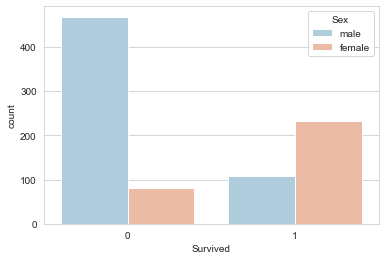

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

**What about any pattern related to passenger class?**

It looks like disproportionately large number of 3rd class passengers died!

<AxesSubplot:xlabel='Survived', ylabel='count'>

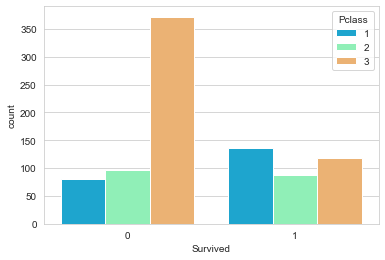

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

**Following code extracts and<br>
plots the fraction of passenger count that survived, <br>
by each class**

<ipython-input-13-5b93321f4ea5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived',data=f_class_survived,palette='RdBu_r')


Text(0.5, 1.0, 'Fraction of passengers survived by class')

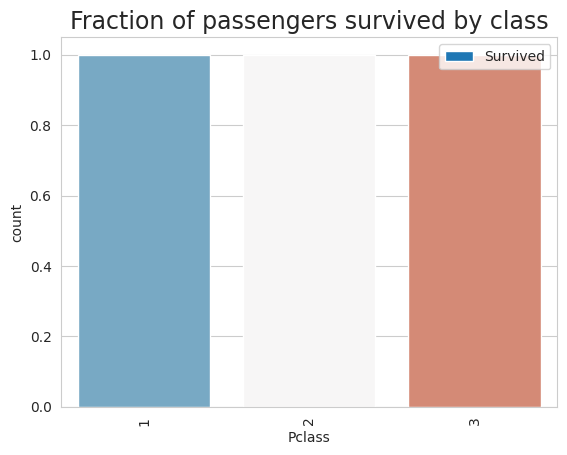

In [13]:
f_class_survived=train.groupby('Pclass')['Survived'].mean()
f_class_survived = pd.DataFrame(f_class_survived)
f_class_survived
f_class_survived.plot.bar(y='Survived')
sns.countplot(x='Survived',data=f_class_survived,palette='RdBu_r')
plt.title("Fraction of passengers survived by class",fontsize=17)

**What about any pattern related to having sibling and spouse?**

It looks like there is a weak trend that chance of survibility increased if there were more number of sibling or spouse

<AxesSubplot:xlabel='Survived', ylabel='count'>

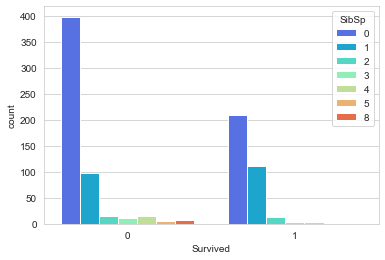

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='SibSp',data=train,palette='rainbow')

**How does the overall age distribution look like?**

<AxesSubplot:title={'center':'Age histogram of the passengers'}, xlabel='Age of the passengers', ylabel='Count'>

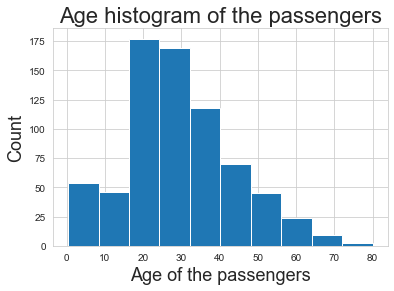

In [ ]:
plt.xlabel("Age of the passengers",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Age histogram of the passengers",fontsize=22)
#train['Age'].hist(bins=30,color='darkred',alpha=0.7,figsize=(10,6))
train['Age'].hist()

**How does the age distribution look like across passenger class?**

It looks like that the average age is different for three classes and it generally decreases from 1st class to 3rd class.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

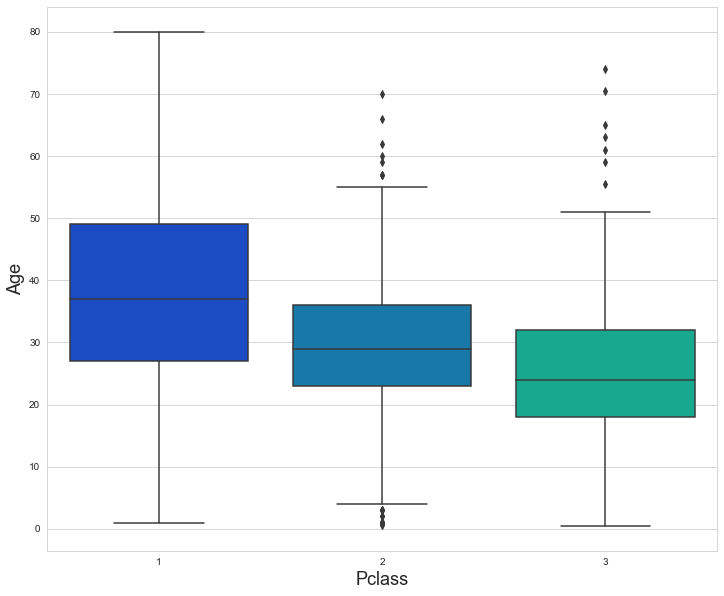

In [ ]:
plt.figure(figsize=(12, 10))
plt.xlabel("Passenger Class",fontsize=18)
plt.ylabel("Age",fontsize=18)
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Text(0.5, 0, 'Passenger class')

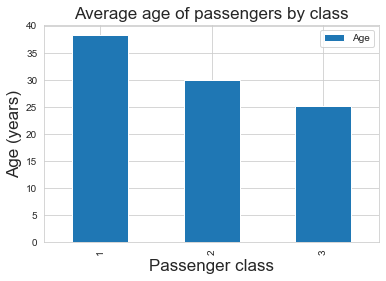

In [ ]:
f_class_Age=train.groupby('Pclass')['Age'].mean()
f_class_Age = pd.DataFrame(f_class_Age)

f_class_Age.plot.bar(y='Age')
plt.title("Average age of passengers by class",fontsize=17)
plt.ylabel("Age (years)", fontsize=17)
plt.xlabel("Passenger class", fontsize=17)

## Data wrangling (impute and drop)
* Impute age (by averaging)
* Drop unncessary features
* Convert categorical features to dummy variables

### Define a function to impute (fill-up missing values) age feature

In [ ]:
a=list(f_class_Age['Age'])
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return a[0]
        elif Pclass == 2:
            return a[1]
        else:
            return a[2]
    else:
        return Age

**Apply the above-defined function and plot the count of numeric features**

Text(0.5, 1.0, 'Bar plot of the count of numeric features')

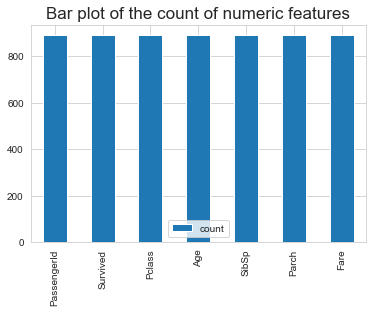

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
d=train.describe()

dT=d.T
dT.plot.bar(y='count')
plt.title("Bar plot of the count of numeric features",fontsize=17)

### Drop the 'Cabin' feature and any other null value

In [ ]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Drop other unnecessary features
like 'Cabin','PassengerId', 'Name', 'Ticket'

In [ ]:
train.drop(['Cabin','PassengerId','Name','Ticket'],axis=1,
           inplace=True)
train.dropna(inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Convert categorial feature like 'Sex'
and 'Embarked' to dummy variables

**Use pandas 'get_dummies()' function**

In [ ]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

KeyError: 'Sex'

**Now drop the 'Sex' and 'Embarked' columns
and concatenate the new dummy variables**

In [ ]:
train.drop(['Sex','Embarked'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

KeyError: "['Sex', 'Embarked'] not found in axis"

This data set is now ready for logistic regression analysis!

## Logistic Regression model fit and prediction

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train.drop('Survived',axis=1),train['Survived'],
    test_size=0.30,random_state=111)

### F1-score as a function of regularization (penalty) parameter

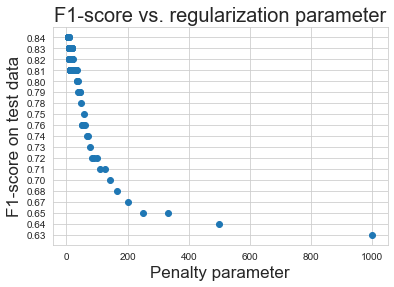

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
nsimu=201
penalty=[0]*nsimu
logmodel=[0]*nsimu
predictions =[0]*nsimu
class_report = [0]*nsimu
f1=[0]*nsimu

for i in range(1,nsimu):
        logmodel[i] =(LogisticRegression(C=i/1000,tol=1e-4, max_iter=int(1e6),
                                         n_jobs=4))
        logmodel[i].fit(X_train,y_train)
        predictions[i] = logmodel[i].predict(X_test)
        class_report[i] = classification_report(y_test,predictions[i])
        l=class_report[i].split()
        f1[i] = l[len(l)-2]
        penalty[i]=1000/i

plt.scatter(penalty[1:len(penalty)-2],f1[1:len(f1)-2])
plt.title("F1-score vs. regularization parameter",fontsize=20)
plt.xlabel("Penalty parameter",fontsize=17)
plt.ylabel("F1-score on test data",fontsize=17)
plt.show()

### F1-score as a function of test set size (fraction)

In [ ]:
nsimu=101
class_report = [0]*nsimu
f1=[0]*nsimu
test_fraction =[0]*nsimu
for i in range(1,nsimu):
        X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1),
                                                    train['Survived'], test_size=0.1+(i-1)*0.007,
                                                    random_state=111)
        logmodel =(LogisticRegression(C=1,tol=1e-4, max_iter=1000,n_jobs=4))
        logmodel.fit(X_train,y_train)
        predictions = logmodel.predict(X_test)
        class_report[i] = classification_report(y_test,predictions)
        l=class_report[i].split()
        f1[i] = l[len(l)-2]
        test_fraction[i]=0.1+(i-1)*0.007

plt.plot(test_fraction[1:len(test_fraction)-2],f1[1:len(f1)-2])
plt.title("F1-score vs. test set size (fraction)",fontsize=20)
plt.xlabel("Test set size (fraction)",fontsize=17)
plt.ylabel("F1-score on test data",fontsize=17)
plt.show()

### F1-score as a function of random seed of test/train split

In [ ]:
nsimu=101
class_report = [0]*nsimu
f1=[0]*nsimu
random_init =[0]*nsimu
for i in range(1,nsimu):
        X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1),
                                                    train['Survived'], test_size=0.3,
                                                    random_state=i+100)
        logmodel =(LogisticRegression(C=1,tol=1e-5, max_iter=1000,n_jobs=4))
        logmodel.fit(X_train,y_train)
        predictions = logmodel.predict(X_test)
        class_report[i] = classification_report(y_test,predictions)
        l=class_report[i].split()
        f1[i] = l[len(l)-2]
        random_init[i]=i+100

plt.plot(random_init[1:len(random_init)-2],f1[1:len(f1)-2])
plt.title("F1-score vs. random initialization seed",fontsize=20)
plt.xlabel("Random initialization seed",fontsize=17)
plt.ylabel("F1-score on test data",fontsize=17)
plt.show()